# Welcome to the Yaw Sweep SG Calibration Package! 

- This notebook is designed to help you to learn how the package can be used. The application over here will show partial plots of the operational data when  trying to identify yaw sweeps and use such operations to calibrate strain gauges. 



#### We will walk you through how to use the package to load data, identify  yaw sweep instants, fit sinusoids to the bending moment data, and calculate calibration factors.

## Prerequisites

Before you get started, make sure that you have the following prerequisite installed:

- Python 3.8 (minimum) 


# Lets go young padawan

## <font color="blue">Step 1:</font>  Install the package 
(-qq will hide unwanted messages)

In [4]:
! pip install -qq yaw-sweep-sg-cali

## <font color="blue">Step 2:</font>  Load needed functions
(these will be commented step by step)

In [5]:
from yaw_sweep_sg_cali.Load_data import (get_SQL_1_min,
                                         get_SQL_50_Hz)
from yaw_sweep_sg_cali.Yaw_sweep_identification import identify_yaw_sweep
from yaw_sweep_sg_cali.Curve_fitting import curve_fitting_ys
from yaw_sweep_sg_cali.Calibration_factors import get_cali_factors

## <font color="blue">Step 3:</font>  Describe the month to be analyzed and the turbine inputs
For now, lets only analyze 1 month each time, so the partial plots work properly, in case more months are wanted, refer to main.py

Feel free to change the start and stop (between January 2018 to March 2022) in a second round and find other yaw sweeps!

November 2018 is a nice first trial! :)

In [6]:
# User Input -> year/month from/to (not inclusive)

start = (2018, 11)
stop = (2018, 12)

# Turbine input file
turbine_file = 'V52_inputs.txt'


***important note*** still the turbine_file data is not included in the package entirely. There are still magical numbers. Forgive me, dear god (Jenni).

Next versions of the package will be uploaded so the user can change such file if another turbine is available :)

## <font color="blue">Step 3:</font>  Load and Save the 1 min data

The function get_SQL_1min would access the V52 DTU SQL database, requiring for the login credentials (that might be restricted).
In order to avoid that, we have provided the "Data" folder. Which already contains the needed data. 

Anyhow, **get_SQL_1min** works for both cases, accessing SQL or loading locally, in the second case scenario make sure to have the right .txt format and in the folders as the in repo.

The output includes yaw, rotor speed, blade pitch and others. (please in case of doubt, refer to the docstrings within the function).

But why 1 min? Because a previous sensitivity analysis was ran and it was concluded that the 50Hz yaw data could be downsampled to 1min data points, and still be able to find yaw sweeps. A downsampling of 3000 can be very useful! 


In [7]:
# Load data from SQL database
data_1_min = get_SQL_1_min(start, stop)

## <font color="blue">Step 4:</font>  Identify Yaw Sweeps in the time-series (if any)

The **identify_yaw_sweep** will search for yaw sweeps in the time-series for n number of months (since we want to have the partial plots, lets keep 1 month range). 

The identification is based on a series of triggers: rotor speed zero, blade pitch around 86, constant yaw rotational speed and at least one full rotation. 

More calmly, it is known that one yaw sweep full rotation should take around 13/14 min. And by so, having 1min data points, the minimum number of consecutives points is 6 (half cycle), and minor chuncks are ignored.

The ***partial_plot*** enables to plotting of each month of data. For several months it is recommended to set as False to avoid several images.

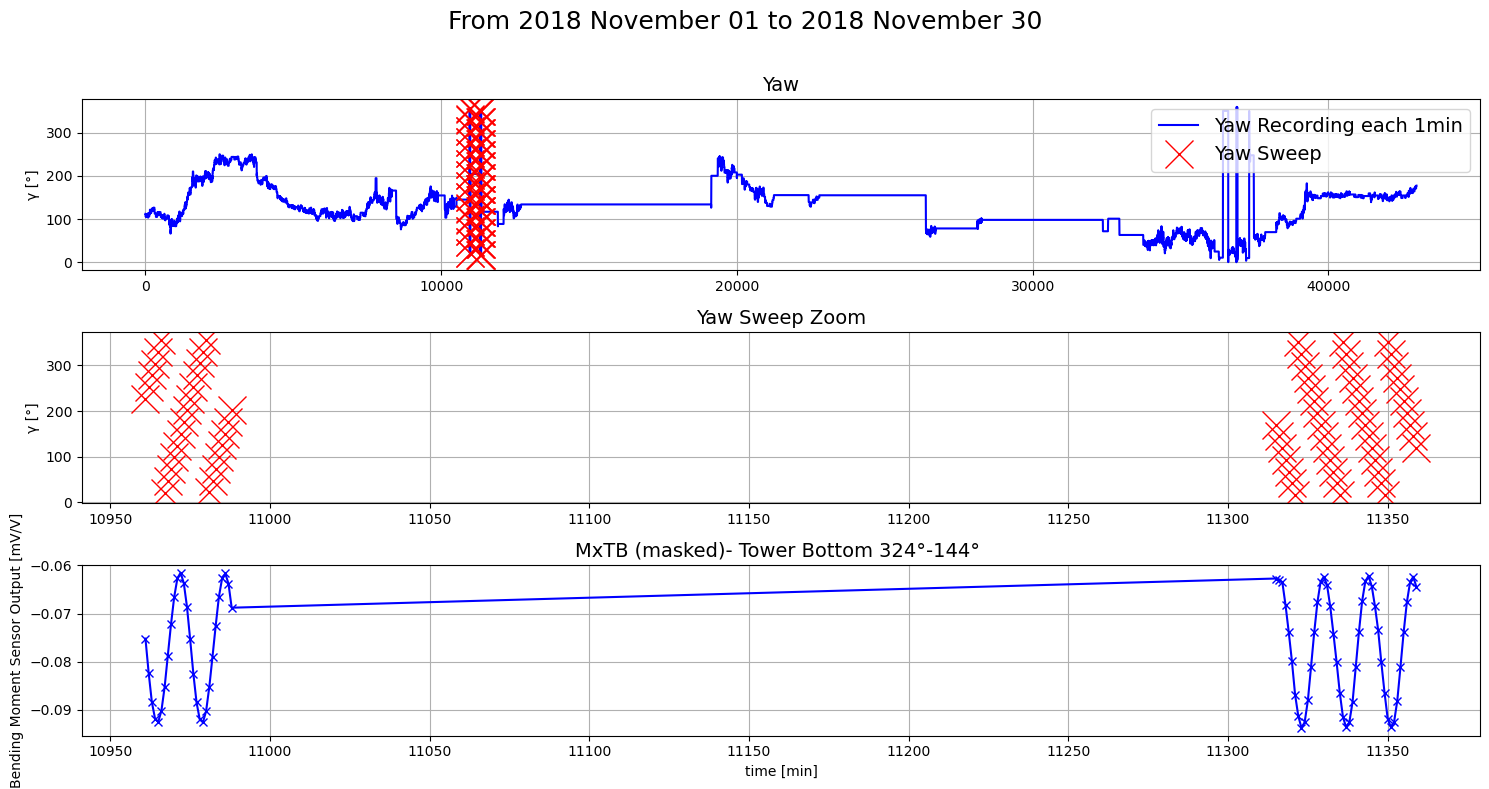

In [8]:
# Identify yaw sweep instants
name_ys, scan_id_ys, numb_ys = identify_yaw_sweep(data_1_min, partial_plot=True)

#### As you can see, two non-consecutive yaw sweep operations are idenfied in November, one with 2 full cycles and the other with 3

#### *indeed the xaxis could be improved using datetime, maybe next time 


## <font color="blue">Step 5:</font>  Load the 50Hz bending moment signal for the found yaw sweeps

The ***get_SQL_50_Hz*** works very similar to ***get_SQL_1_min***, but now only bending moment signal is loaded and with the 50Hz sampling frequency in 10min group of data, including from the start to the end of each idenfied yaw sweep for the given month.

In [9]:
# Load data at 50 Hz
data_50_Hz = get_SQL_50_Hz(name_ys)

## <font color="blue">Step 6:</font>  Curve fit sinus curves into the Bending Moment signal

But why? So to filter the noise out of the raw signal, and have good estimates of max, min, mean from the bending moment recorded by the strain gauge while in the yaw sweep. ***curve_fitting_ys*** automatically fits sinus curves to several yaw sweeps idenfied. 

The output will contain also performance and error related to the curve fitting function. It is worth mentioning, that the full 10min loaded data is cutted only around the yaw sweep by a function, to faciliate the curve fitting and attenuate errors. 

***fitted_curve_outputs*** is a dictionary containing many nice information.

***warnings*** is a list of yaw sweep time ranges identifed where the fitting functions did not succeeded to fit a sinus. The signal might be too noisy or inconsistancy.

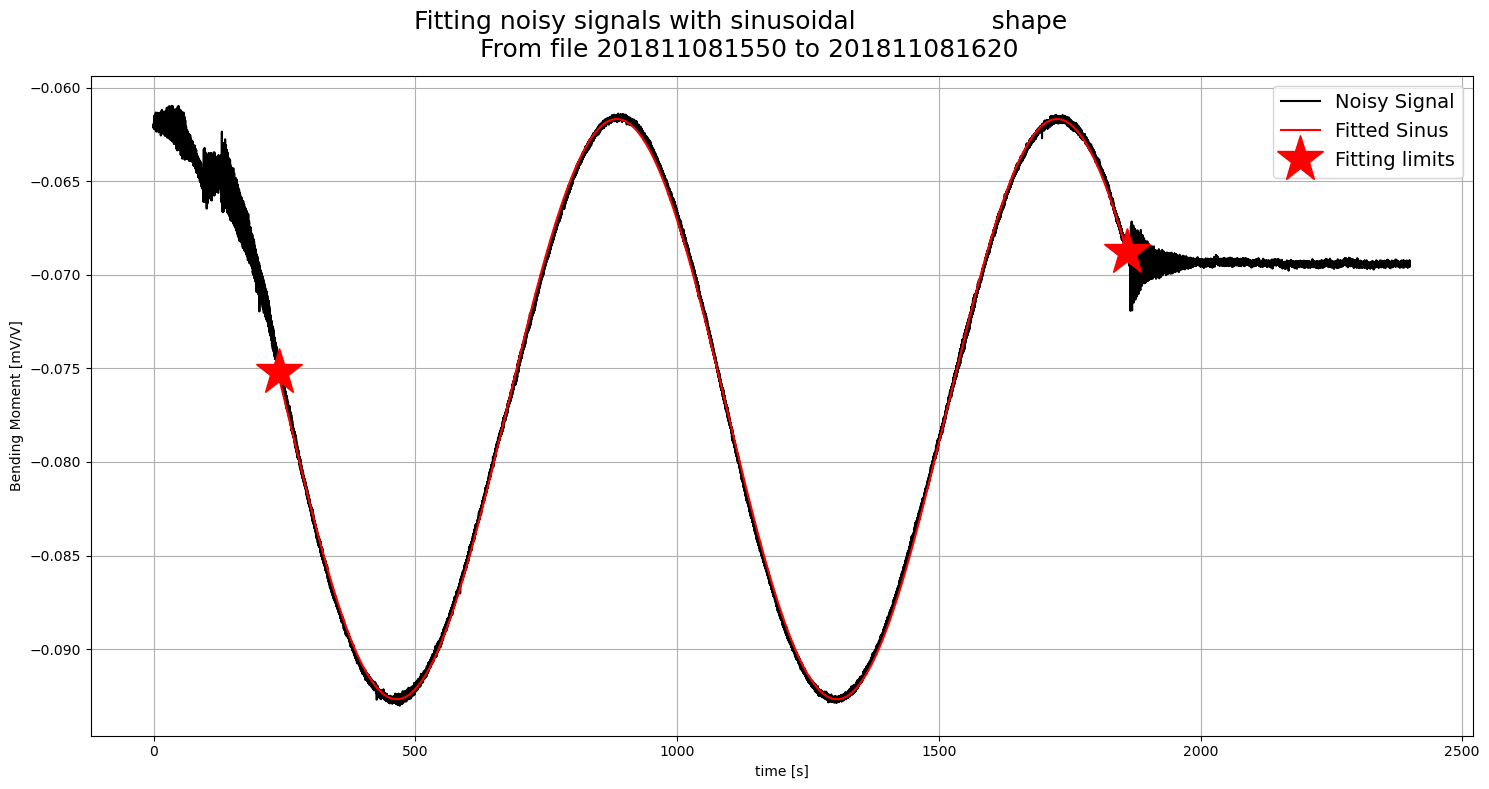

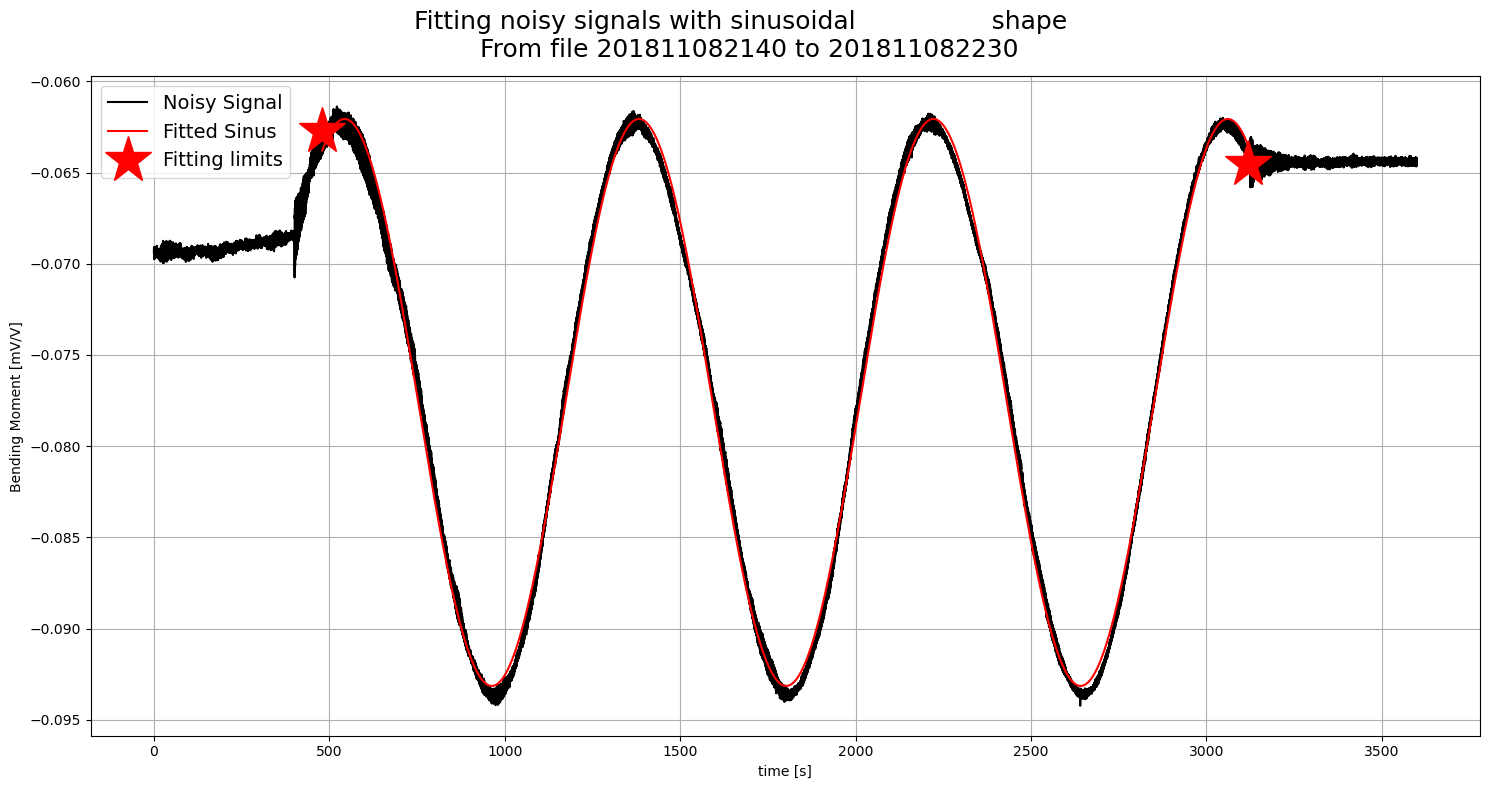

In [10]:
# Fit sinusoids to the data
fitted_curve_outputs, warnings = curve_fitting_ys(numb_ys, data_50_Hz,
                                                  name_ys, scan_id_ys,
                                                  partial_plot=True)

#### The format of the header is as included in the DTU V52 database 

##### e.g. 201811082140 as 08 November 2018 at 21h40

## <font color="blue">Step 7:</font>  Generate the Strain Gauge Calibration Factors

Based on the offset and gain of the fitted curve, we can translate the measured strain gauge signal [mV/V] into stresses, and then, bending moments [kNm], by using the ***get_cali_factors***

This linear relationship (gain) is turbine dependent and also dependent on the section of the tower (cross section). For the V52 MxTB sensor, the values are included in the turbine_file. In a summarized way, the gain depends on the strain gauge bridge configuration, on the material specification and on the cross section where the strain gauges are mounted.

The ***calibration_factors*** will be an extender dictionary based on the input but now with more physical meaningful values.

In case ***plot*** is True, the different calibration factors (offset and gain) will be plotted over time, considering the offset uncertainty and also the mean wind speed during the yaw sweep identified. 

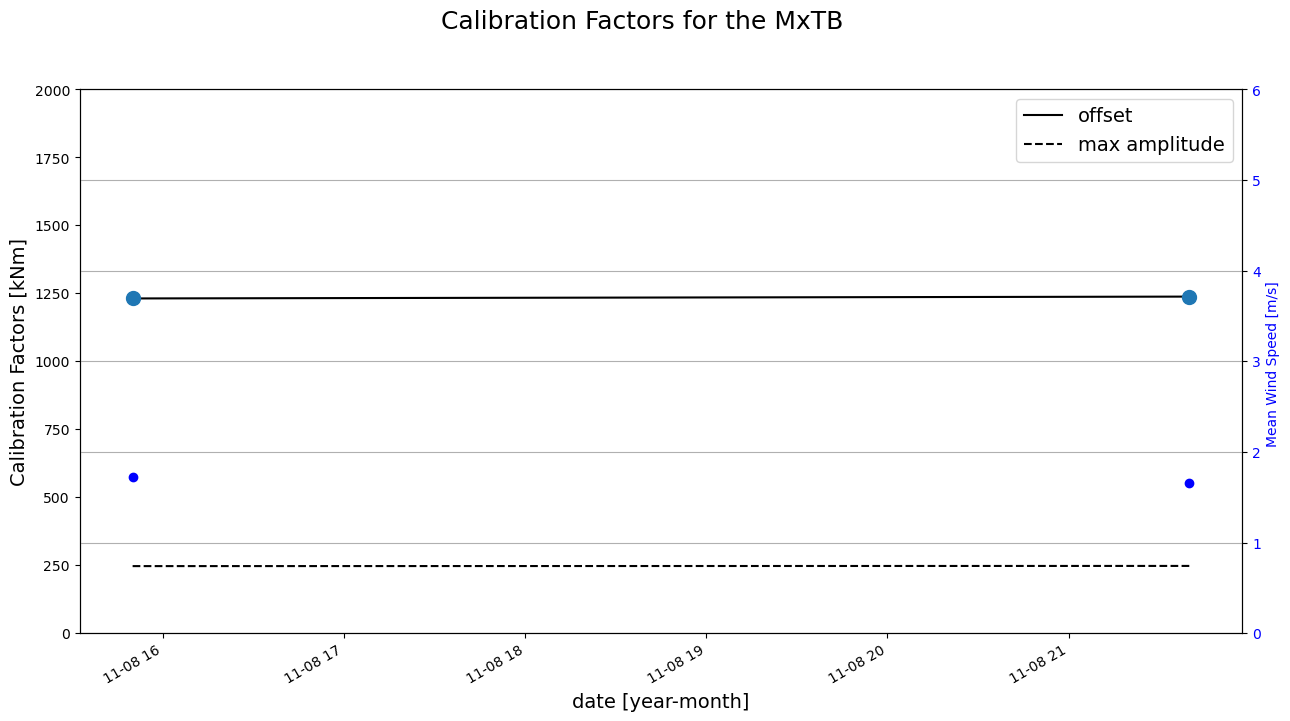

In [11]:
# Calculate calibration factors
calibration_factors = get_cali_factors(fitted_curve_outputs,
                                       turbine_file,
                                       warnings,
                                       plot=True)

# Congratulations!
You have successfully used the Yaw Sweep SG Calibration Package to analyze operational data and generate preliminary* calibrate factors for strain gauges.

*as we still need to work a bit on how to the final data in terms of fitting performance, mean wind speed (lower the better, right?) and come up with proper suggestion of calibration factors per month (averaging?).





## But come on! This is a pretty simple plot. 

Try running start and stop from January 2018 to April 2022 (available data). And lets see how the calibration factors vary with time. 

You might considered setting partial_plot as False in both the identify_yaw_sweep() and the curve_fitting_ys() to avoid priting messages :)

Or use main.py which is already ajusted for such use. 